# Programming and Mathematics for AI: Task 4

# Part 1: Implement a Neural Network (Baseline)

Imports

In [ ]:
# NumPy
import numpy as np

# PyTorch - Open-source machine learning framework
import torch
import torch.nn as nn # Neural network
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

#Torchvision - Package consisting of popular datasets, model architectures, and common image transformations for computer vision
import torchvision
# from torchvision import datasets # Possibly remove
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10 # Dataset
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

# Matplotlib - Visualising data
import matplotlib.pyplot as plt
%matplotlib inline


Downloading CIFAR-10 dataset, and examining its contents. 50,000 images are intended for training, and 10,000 for testing.  We will split this further by including a validation set of 5,000 images from the training set.

In [ ]:
training_data = CIFAR10(root = 'data/', download = True, transform = ToTensor())

testing_data = CIFAR10(root = 'data/', train = False, transform = ToTensor())

Files already downloaded and verified


In [ ]:
classes = training_data.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
training_data_size = len(training_data)
training_data_size

50000

In [ ]:
testing_data_size = len(testing_data)
testing_data_size

10000

In [ ]:
classes_count = len(training_data.classes)
classes_count

10

In [ ]:
# Image shape
image, label = training_data[0]
image_shape = image.shape
image_shape

torch.Size([3, 32, 32])

Further splitting data to get a validation set.  Using a seed value to ensure the same validation set is always used.

In [ ]:
# Validation data size
validation_size = 5000
# New training data size
training_size = len(training_data) - validation_size
# Random seed for reproducibility
torch.manual_seed(25)

Using random split on training data to allocate 5,000 images to validation.

In [ ]:
training_data, validation_data = random_split(training_data, [training_size, validation_size])

# Final datasets
print(len(training_data)) # Data used to fit the model
print(len(validation_data)) # Data used to fine-tune the model hyperparameters
print(len(testing_data)) # Data used to provide an unbiased evaluation of a final NN

45000
5000
10000


Baseline Parameters

Batch size defines the number of samples that will be propagated through the neural network, number of epochs determines training times, optimiser function has several options.  Learning rate describes the rate at which the model optimises.

In [ ]:
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

Data loaders for training, validation, testing sets.  We used shuffle for the training data loader so that batches are different per epoch during training.  This boosts generalisation. 2 workers are used, as recommended by colab.

In [ ]:
training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)

testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

# Building the Neural Network

Function to determine model accuracy

In [ ]:
def determine_accuracy(outputs, labels):
    """Determine accuracy via predictions"""
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class NeuralNetwork(nn.Module):

    def train_batch(self, batch):
        """Training batch: making predictions and determining loss"""

        batch_images, batch_labels = batch

        # Make predictions
        out = self(batch_images)

        # Determine batch loss
        batch_loss = F.cross_entropy(out, batch_labels)
        return batch_loss
    
    def validate_batch(self, batch):
        """Validating batch: making predictions, determining loss and accuracy"""

        batch_images, batch_labels = batch

        # Make predictions
        out = self(batch_images)

        # Determine loss
        batch_loss = F.cross_entropy(out, batch_labels)

        # Calculate accuracy
        accuracy = determine_accuracy(out, batch_labels)
        return {'validation_loss': batch_loss.detach(), 'validation_accuracy': accuracy}
        
    def validate_epoch(self, outputs):
        """Validate batches at the end of epoch"""

        # Losses across epochs
        epoch_losses = [x['validation_loss'] for x in outputs]

        # Combining losses using mean
        combined_epoch_loss = torch.stack(epoch_losses).mean()

        # Accuracies across epochs
        epoch_accs = [x['validation_accuracy'] for x in outputs]

        # Combining accuracies using mean
        combined_epoch_acc = torch.stack(epoch_accs).mean()

        return {'validation_loss': combined_epoch_loss.item(), 'validation_accuracy': combined_epoch_acc.item()}
    
    def print_epoch(self, epoch, result):
        """Print epoch number, validation loss and accuracy at the end of each epoch"""

        print("Epoch {} | validation_loss: {:.4f} | validation_accuracy: {:.4f}".format(epoch, result['validation_loss'], result['validation_accuracy']))

Function to evaluate model using model's internal functions

In [ ]:
def validate_model(model, validation_loader):
    """Model validation"""

    outputs = [model.validate_batch(batch) for batch in validation_loader]
    return model.validate_epoch(outputs)


Function to train model using evaluation function above, and model's internal training functions.

In [ ]:
def fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function):
    """Model training and validation"""

    # Model history
    model_history = []

    # Model optimiser
    model_optimiser = optimiser_function(model.parameters(), learning_rate)

    for epoch in range(epochs):

        # Training
        for batch in training_loader:

            loss = model.train_batch(batch)
            loss.backward()

            model_optimiser.step()
            model_optimiser.zero_grad()

        # Validation
        result = validate_model(model, validation_loader)
        model.print_epoch(epoch, result)
        model_history.append(result)

    return model_history

Checking the use of a dedicated GPU: In our case we mostly used CPUs.

In [ ]:
def get_device():
    """Use dedicated GPU if available, else use CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_device()
print(device)

cpu


In [ ]:
def move_to_device(data, device):
    """Move data to GPU/CPU"""
    if isinstance(data, (list,tuple)):
        # Using recursion if required
        return [move_to_device(x, device) for x in data]

    return data.to(device, non_blocking=True)


Function to plot loss across model history.

In [ ]:
def plot_losses(history):
    """Plot loss across model history"""

    losses = [x['validation_loss'] for x in history]

    # Plotting using pyplot
    plt.plot(losses, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss against epochs');

Function to plot accuracy across model history.

In [ ]:
def plot_accuracies(history):
    """Plot accuracy across model history"""

    accuracies = [x['validation_accuracy'] for x in history]

    # Plotting using pyplot
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy against epochs');

Data Loaders

In [ ]:

class DeviceDataLoader():
    """Move data to a device"""

    def __init__(self, data_loader, device):
        self.data_loader = data_loader
        self.device = device
      
    def __len__(self):
        """Batch count"""

        return len(self.data_loader)
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        
        for b in self.data_loader: 
            yield move_to_device(b, self.device)

    

In [ ]:
training_loader = DeviceDataLoader(training_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
testing_loader = DeviceDataLoader(testing_loader, device)

# Training the Neural Network

In [ ]:
# Input and output

input_size = 3*32*32

output_size = 10

In [ ]:
class Model_1(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

Move model to device

In [ ]:
model = move_to_device(Model_1(), device)

In [ ]:
history = [validate_model(model, validation_loader)]
print(history)

[{'validation_loss': 2.304971694946289, 'validation_accuracy': 0.12934282422065735}]


In [ ]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.9605 | validation_accuracy: 0.2781
Epoch 1 | validation_loss: 1.7406 | validation_accuracy: 0.3785
Epoch 2 | validation_loss: 1.7545 | validation_accuracy: 0.3676
Epoch 3 | validation_loss: 1.7191 | validation_accuracy: 0.3739
Epoch 4 | validation_loss: 1.6077 | validation_accuracy: 0.4213
Epoch 5 | validation_loss: 1.5913 | validation_accuracy: 0.4380
Epoch 6 | validation_loss: 1.5850 | validation_accuracy: 0.4263
Epoch 7 | validation_loss: 1.6291 | validation_accuracy: 0.4145
Epoch 8 | validation_loss: 1.4978 | validation_accuracy: 0.4650
Epoch 9 | validation_loss: 1.5688 | validation_accuracy: 0.4414


Initial results

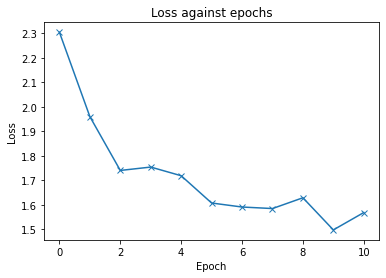

In [ ]:
plot_losses(history)

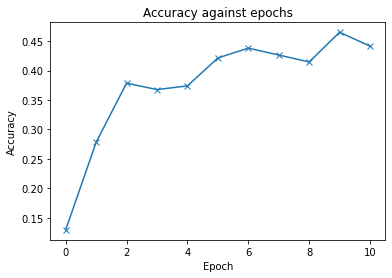

In [ ]:
plot_accuracies(history)

In [ ]:
learning_rate = 1e-2

In [ ]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.4103 | validation_accuracy: 0.4965
Epoch 1 | validation_loss: 1.4036 | validation_accuracy: 0.5026
Epoch 2 | validation_loss: 1.4050 | validation_accuracy: 0.5000
Epoch 3 | validation_loss: 1.3969 | validation_accuracy: 0.4999
Epoch 4 | validation_loss: 1.3950 | validation_accuracy: 0.5037
Epoch 5 | validation_loss: 1.3949 | validation_accuracy: 0.5008
Epoch 6 | validation_loss: 1.3830 | validation_accuracy: 0.5082
Epoch 7 | validation_loss: 1.3925 | validation_accuracy: 0.5030
Epoch 8 | validation_loss: 1.3801 | validation_accuracy: 0.5099
Epoch 9 | validation_loss: 1.3848 | validation_accuracy: 0.5050


In [ ]:
learning_rate = 1e-3

In [ ]:
history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

Epoch 0 | validation_loss: 1.3705 | validation_accuracy: 0.5099
Epoch 1 | validation_loss: 1.3735 | validation_accuracy: 0.5075
Epoch 2 | validation_loss: 1.3715 | validation_accuracy: 0.5081
Epoch 3 | validation_loss: 1.3688 | validation_accuracy: 0.5124
Epoch 4 | validation_loss: 1.3769 | validation_accuracy: 0.5063
Epoch 5 | validation_loss: 1.3719 | validation_accuracy: 0.5078
Epoch 6 | validation_loss: 1.3693 | validation_accuracy: 0.5083
Epoch 7 | validation_loss: 1.3687 | validation_accuracy: 0.5110
Epoch 8 | validation_loss: 1.3715 | validation_accuracy: 0.5092
Epoch 9 | validation_loss: 1.3679 | validation_accuracy: 0.5104


Plotting losses across all epochs

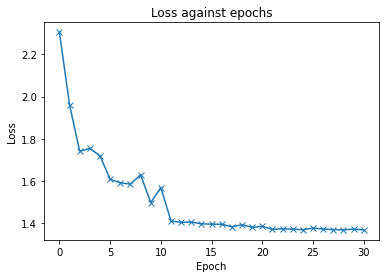

In [ ]:
plot_losses(history)

Plotting accuracies across all epochs

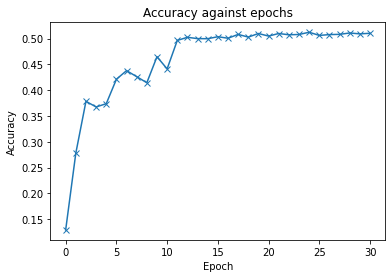

In [ ]:
plot_accuracies(history)

Evaluating model using the testing data and validate_model function

In [ ]:
validate_model(model, testing_loader)

{'validation_accuracy': 0.5194336175918579,
 'validation_loss': 1.3510839939117432}

In [ ]:
# ...

# Part 2: Propose Improvements (TO-DO)

# Part 3: Tuning Parameters

Running baseline model while varying number of epochs: 10, 25, 50

In [ ]:
batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.302825927734375, 'validation_accuracy': 0.09605928510427475}]
Epoch 0 | validation_loss: 2.0810 | validation_accuracy: 0.2538
Epoch 1 | validation_loss: 1.7322 | validation_accuracy: 0.4004
Epoch 2 | validation_loss: 1.7733 | validation_accuracy: 0.3687
Epoch 3 | validation_loss: 1.6418 | validation_accuracy: 0.4161
Epoch 4 | validation_loss: 1.6697 | validation_accuracy: 0.3875
Epoch 5 | validation_loss: 1.5580 | validation_accuracy: 0.4399
Epoch 6 | validation_loss: 1.5645 | validation_accuracy: 0.4505
Epoch 7 | validation_loss: 1.4905 | validation_accuracy: 0.4768
Epoch 8 | validation_loss: 1.5185 | validation_accuracy: 0.4611
Epoch 9 | validation_loss: 1.5167 | validation_accuracy: 0.4637


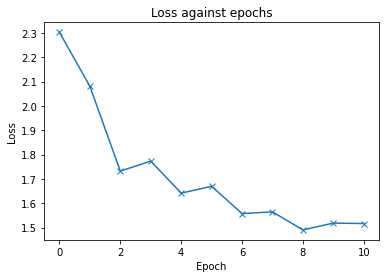

In [ ]:
plot_losses(history)

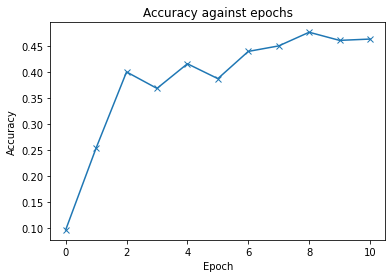

In [ ]:
plot_accuracies(history)

In [ ]:
epochs = 25
model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.306105136871338, 'validation_accuracy': 0.10211397707462311}]
Epoch 0 | validation_loss: 1.9309 | validation_accuracy: 0.3076
Epoch 1 | validation_loss: 1.7534 | validation_accuracy: 0.3744
Epoch 2 | validation_loss: 1.7329 | validation_accuracy: 0.3774
Epoch 3 | validation_loss: 1.6365 | validation_accuracy: 0.4231
Epoch 4 | validation_loss: 1.6217 | validation_accuracy: 0.4275
Epoch 5 | validation_loss: 1.6471 | validation_accuracy: 0.4125
Epoch 6 | validation_loss: 1.5389 | validation_accuracy: 0.4542
Epoch 7 | validation_loss: 1.5984 | validation_accuracy: 0.4241
Epoch 8 | validation_loss: 1.6112 | validation_accuracy: 0.4278
Epoch 9 | validation_loss: 1.6000 | validation_accuracy: 0.4298
Epoch 10 | validation_loss: 1.5803 | validation_accuracy: 0.4400
Epoch 11 | validation_loss: 1.5015 | validation_accuracy: 0.4696
Epoch 12 | validation_loss: 1.4754 | validation_accuracy: 0.4771
Epoch 13 | validation_loss: 1.6731 | validation_accuracy: 0.4095
Epoch 14 | vali

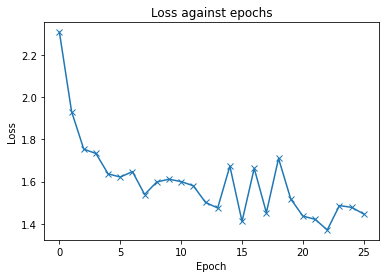

In [ ]:
plot_losses(history)

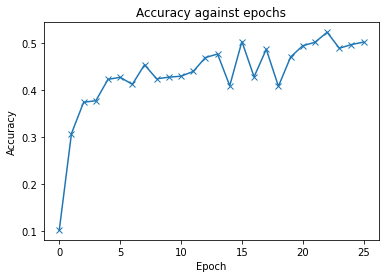

In [ ]:
plot_accuracies(history)

In [ ]:
epochs = 50
model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.304243803024292, 'validation_accuracy': 0.10150505602359772}]
Epoch 0 | validation_loss: 1.9093 | validation_accuracy: 0.3227
Epoch 1 | validation_loss: 1.7568 | validation_accuracy: 0.3612
Epoch 2 | validation_loss: 1.8388 | validation_accuracy: 0.3497
Epoch 3 | validation_loss: 1.6821 | validation_accuracy: 0.3978
Epoch 4 | validation_loss: 1.7332 | validation_accuracy: 0.3905
Epoch 5 | validation_loss: 1.7219 | validation_accuracy: 0.3993
Epoch 6 | validation_loss: 1.5143 | validation_accuracy: 0.4587
Epoch 7 | validation_loss: 1.6327 | validation_accuracy: 0.4188
Epoch 8 | validation_loss: 1.5876 | validation_accuracy: 0.4250
Epoch 9 | validation_loss: 1.5311 | validation_accuracy: 0.4478
Epoch 10 | validation_loss: 1.4864 | validation_accuracy: 0.4724
Epoch 11 | validation_loss: 1.7197 | validation_accuracy: 0.3928
Epoch 12 | validation_loss: 1.4575 | validation_accuracy: 0.4757
Epoch 13 | validation_loss: 1.5350 | validation_accuracy: 0.4594
Epoch 14 | vali

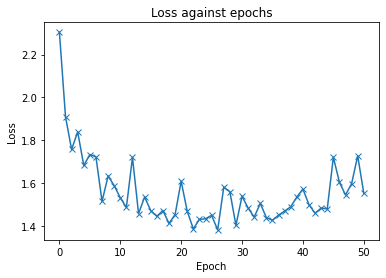

In [ ]:
plot_losses(history)

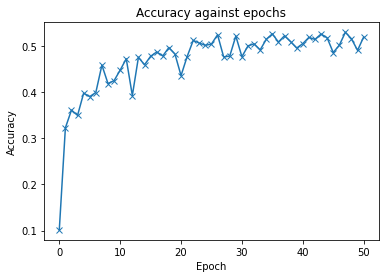

In [ ]:
plot_accuracies(history)

Varying batch size: 64, 128, 256

In [ ]:
# Baseline: 128

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

In [ ]:
training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.300751209259033, 'validation_accuracy': 0.10597427189350128}]
Epoch 0 | validation_loss: 1.8505 | validation_accuracy: 0.3342
Epoch 1 | validation_loss: 1.7839 | validation_accuracy: 0.3593
Epoch 2 | validation_loss: 1.7534 | validation_accuracy: 0.3621
Epoch 3 | validation_loss: 1.7082 | validation_accuracy: 0.3807
Epoch 4 | validation_loss: 1.5773 | validation_accuracy: 0.4377
Epoch 5 | validation_loss: 1.5562 | validation_accuracy: 0.4449
Epoch 6 | validation_loss: 1.6262 | validation_accuracy: 0.4203
Epoch 7 | validation_loss: 1.4983 | validation_accuracy: 0.4676
Epoch 8 | validation_loss: 1.5994 | validation_accuracy: 0.4288
Epoch 9 | validation_loss: 1.5402 | validation_accuracy: 0.4537


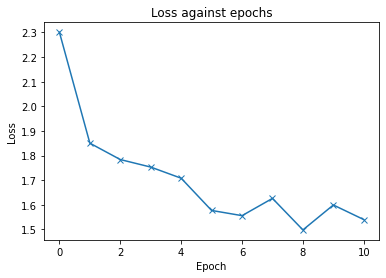

In [ ]:
plot_losses(history)

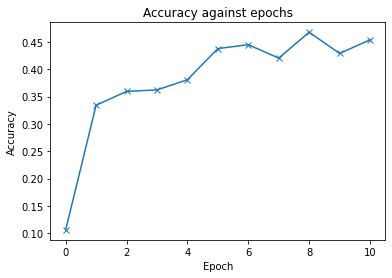

In [ ]:
plot_accuracies(history)

In [ ]:
# Lower: 64

batch_size = 64

training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.305284261703491, 'validation_accuracy': 0.09453125298023224}]
Epoch 0 | validation_loss: 2.3065 | validation_accuracy: 0.2336
Epoch 1 | validation_loss: 2.5506 | validation_accuracy: 0.2525
Epoch 2 | validation_loss: 1.7288 | validation_accuracy: 0.3834
Epoch 3 | validation_loss: 1.9210 | validation_accuracy: 0.3387
Epoch 4 | validation_loss: 2.1148 | validation_accuracy: 0.3355
Epoch 5 | validation_loss: 2.0205 | validation_accuracy: 0.3258
Epoch 6 | validation_loss: 2.1173 | validation_accuracy: 0.2963
Epoch 7 | validation_loss: 1.9918 | validation_accuracy: 0.3623
Epoch 8 | validation_loss: 1.5198 | validation_accuracy: 0.4662
Epoch 9 | validation_loss: 1.7490 | validation_accuracy: 0.4129


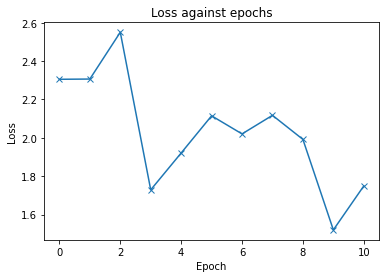

In [ ]:
plot_losses(history)

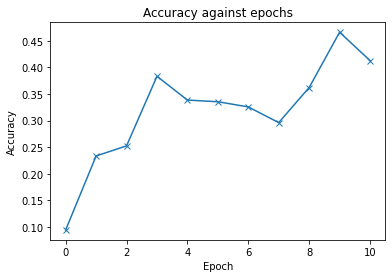

In [ ]:
plot_accuracies(history)

In [ ]:
# Higher: 256

batch_size = 256

training_loader = DataLoader(training_data, batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_data, batch_size*2, num_workers, pin_memory=True)
testing_loader = DataLoader(testing_data, batch_size*2, num_workers, pin_memory=True)

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.301886796951294, 'validation_accuracy': 0.10058991611003876}]
Epoch 0 | validation_loss: 1.9895 | validation_accuracy: 0.2868
Epoch 1 | validation_loss: 1.8186 | validation_accuracy: 0.3485
Epoch 2 | validation_loss: 1.7454 | validation_accuracy: 0.3784
Epoch 3 | validation_loss: 1.6967 | validation_accuracy: 0.4102
Epoch 4 | validation_loss: 1.6603 | validation_accuracy: 0.4168
Epoch 5 | validation_loss: 1.7103 | validation_accuracy: 0.3922
Epoch 6 | validation_loss: 1.6157 | validation_accuracy: 0.4282
Epoch 7 | validation_loss: 1.6379 | validation_accuracy: 0.4261
Epoch 8 | validation_loss: 1.5684 | validation_accuracy: 0.4426
Epoch 9 | validation_loss: 1.5369 | validation_accuracy: 0.4539


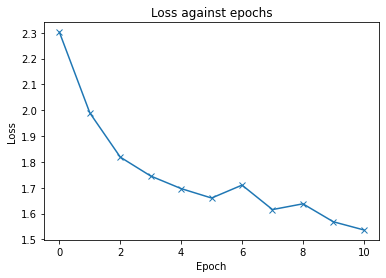

In [ ]:
plot_losses(history)

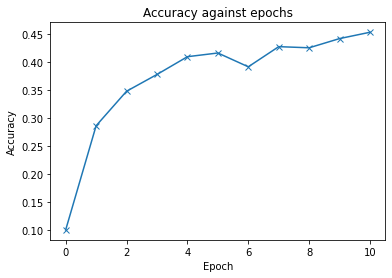

In [ ]:
plot_accuracies(history)

Varying optimisation function: Stochastic Gradient Descent vs Adam

In [ ]:
# Baseline: SGD

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.304863214492798, 'validation_accuracy': 0.0949537605047226}]
Epoch 0 | validation_loss: 1.9439 | validation_accuracy: 0.2855
Epoch 1 | validation_loss: 1.9239 | validation_accuracy: 0.2967
Epoch 2 | validation_loss: 1.7698 | validation_accuracy: 0.3723
Epoch 3 | validation_loss: 1.6878 | validation_accuracy: 0.4017
Epoch 4 | validation_loss: 1.7160 | validation_accuracy: 0.3839
Epoch 5 | validation_loss: 1.6323 | validation_accuracy: 0.4222
Epoch 6 | validation_loss: 1.6125 | validation_accuracy: 0.4254
Epoch 7 | validation_loss: 1.6219 | validation_accuracy: 0.4193
Epoch 8 | validation_loss: 1.6899 | validation_accuracy: 0.4131
Epoch 9 | validation_loss: 1.7918 | validation_accuracy: 0.3974


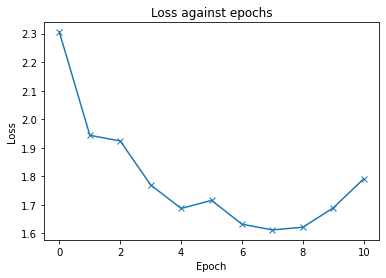

In [ ]:
plot_losses(history)

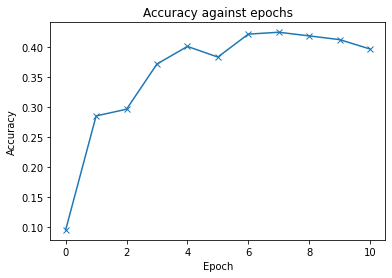

In [ ]:
plot_accuracies(history)

In [ ]:
# Alternative optimiser function: Adam

optimiser_function = torch.optim.Adam

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3037421703338623, 'validation_accuracy': 0.10213647782802582}]
Epoch 0 | validation_loss: 2.6360 | validation_accuracy: 0.1059
Epoch 1 | validation_loss: 2.6395 | validation_accuracy: 0.1065
Epoch 2 | validation_loss: 2.6380 | validation_accuracy: 0.0930
Epoch 3 | validation_loss: 2.7402 | validation_accuracy: 0.1013
Epoch 4 | validation_loss: 2.6379 | validation_accuracy: 0.1008
Epoch 5 | validation_loss: 2.6378 | validation_accuracy: 0.0997
Epoch 6 | validation_loss: 2.6392 | validation_accuracy: 0.1010
Epoch 7 | validation_loss: 2.6387 | validation_accuracy: 0.0978
Epoch 8 | validation_loss: 2.6429 | validation_accuracy: 0.0899
Epoch 9 | validation_loss: 2.6438 | validation_accuracy: 0.0898


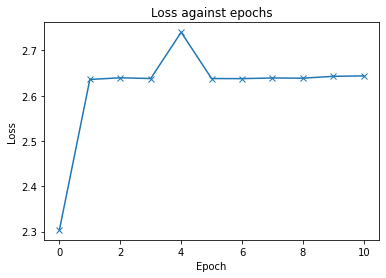

In [ ]:
plot_losses(history)

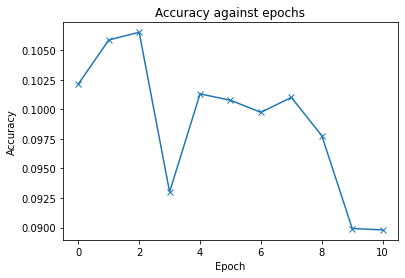

In [ ]:
plot_accuracies(history)

Varying learning rate: 0.1, 0.01, 0.001

In [ ]:
# Baseline: 0.1

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3060407638549805, 'validation_accuracy': 0.09749680757522583}]
Epoch 0 | validation_loss: 1.9461 | validation_accuracy: 0.2966
Epoch 1 | validation_loss: 1.8330 | validation_accuracy: 0.3433
Epoch 2 | validation_loss: 1.8166 | validation_accuracy: 0.3514
Epoch 3 | validation_loss: 1.7329 | validation_accuracy: 0.3839
Epoch 4 | validation_loss: 1.6718 | validation_accuracy: 0.4125
Epoch 5 | validation_loss: 1.6464 | validation_accuracy: 0.4202
Epoch 6 | validation_loss: 1.6116 | validation_accuracy: 0.4326
Epoch 7 | validation_loss: 1.6462 | validation_accuracy: 0.4167
Epoch 8 | validation_loss: 1.6148 | validation_accuracy: 0.4346
Epoch 9 | validation_loss: 1.6276 | validation_accuracy: 0.4140


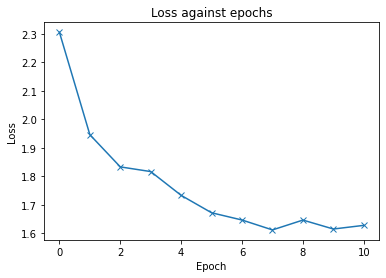

In [ ]:
plot_losses(history)

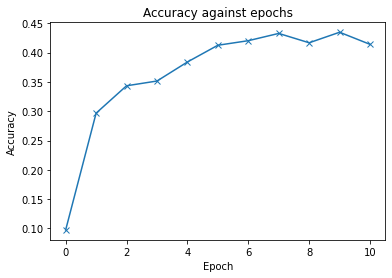

In [ ]:
plot_accuracies(history)

In [ ]:
# 0.01

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.01 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3041253089904785, 'validation_accuracy': 0.11256377398967743}]
Epoch 0 | validation_loss: 2.2402 | validation_accuracy: 0.1931
Epoch 1 | validation_loss: 2.1294 | validation_accuracy: 0.2456
Epoch 2 | validation_loss: 2.0316 | validation_accuracy: 0.2662
Epoch 3 | validation_loss: 1.9763 | validation_accuracy: 0.2913
Epoch 4 | validation_loss: 1.9402 | validation_accuracy: 0.3073
Epoch 5 | validation_loss: 1.9108 | validation_accuracy: 0.3247
Epoch 6 | validation_loss: 1.8889 | validation_accuracy: 0.3350
Epoch 7 | validation_loss: 1.8774 | validation_accuracy: 0.3394
Epoch 8 | validation_loss: 1.8544 | validation_accuracy: 0.3454
Epoch 9 | validation_loss: 1.8325 | validation_accuracy: 0.3578


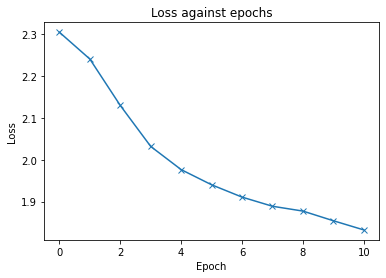

In [ ]:
plot_losses(history)

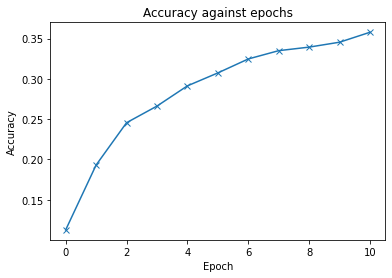

In [ ]:
plot_accuracies(history)

In [ ]:
# 0.001

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

[{'validation_loss': 2.3038322925567627, 'validation_accuracy': 0.10817523300647736}]
Epoch 0 | validation_loss: 1.9622 | validation_accuracy: 0.2843
Epoch 1 | validation_loss: 1.8302 | validation_accuracy: 0.3423
Epoch 2 | validation_loss: 1.8687 | validation_accuracy: 0.3234
Epoch 3 | validation_loss: 1.7747 | validation_accuracy: 0.3714
Epoch 4 | validation_loss: 1.6630 | validation_accuracy: 0.4241
Epoch 5 | validation_loss: 1.6503 | validation_accuracy: 0.4307
Epoch 6 | validation_loss: 1.6016 | validation_accuracy: 0.4358
Epoch 7 | validation_loss: 1.5900 | validation_accuracy: 0.4376
Epoch 8 | validation_loss: 1.5436 | validation_accuracy: 0.4550
Epoch 9 | validation_loss: 1.7348 | validation_accuracy: 0.3912


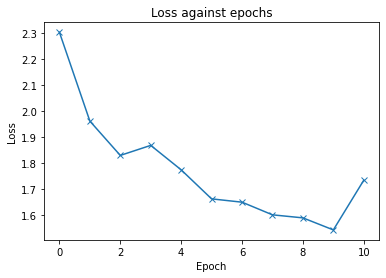

In [ ]:
plot_losses(history)

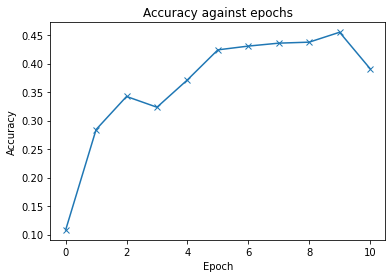

In [ ]:
plot_accuracies(history)

Varying number of hidden layers: Baseline, two hidden, three hidden

In [ ]:
# Baseline

batch_size = 128 # Number of images loaded into network at once
epochs = 10 # Training run time
optimiser_function = torch.optim.SGD # Optimiser function - set to Stochastic Gradient Descent
learning_rate = 0.1 #1e-1 # Rate of optimisation
num_workers = 2 # subprocesses to use for data loading

model = move_to_device(Model_1(), device)

history = [validate_model(model, validation_loader)]
print(history)

history += fit_model(epochs, learning_rate, model, training_loader, validation_loader, optimiser_function)

In [ ]:
# Two hidden layers

In [ ]:
class Model_two_hidden(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
class Model_three_hidden(NeuralNetwork):
    def __init__(self):

        super().__init__()
        self.linear1 = nn.Linear(input_size, 256)
        self.linear2 = nn.Linear(256, 128)
        self.linear3 = nn.Linear(256, 128)
        self.linear4 = nn.Linear(256, 128)
        self.linear5 = nn.Linear(128, output_size)
        
    def forward(self, x):

        # Flatten images into vectors
        x = x.view(x.size(0), -1)

        # Apply layers & activation functions
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

Varying number of nodes in hidden layers

In [ ]:
# Baseline: 

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
# 

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)

In [ ]:
#

In [ ]:
plot_losses(history)

In [ ]:
plot_accuracies(history)